### File Explanation

**trainRNN_AttentionModel_dropout.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create an "Attention Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model from fixed length sequences (function: **dynamicLSTM_Attention** in **trainRNN_network_utils.py**)
<br> 5) Create an attention mechanism based on a fully-connected layer of states and output, which is followed by a tanh layer to calculate scores. Then, calculate attention weights and context vector using softmax and dense layers 
<br> 6) Create a single output from a concatenation of context vectors of gene A and gene B
<br> 7) Pass the output through a **dense** layer and make prediction
<br> 8) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 9) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 10) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 11) Save them in "resultsAttentionDropout_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 5) **attention_matrixA**: Attention weights of gene A, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 6) **attention_matrixB**: Attention weights of gene B, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 7) **tst_prediction**: Test predictions, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import pandas as pd
import sys
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData.ipynb"

# Save data into Python file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )

# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [7]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [9]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
attention_matrixA = {}
attention_matrixB = {}
tst_prediction = {}

for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM_Attention(rSnpRnaA_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_A = current_state_A[-1].h

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM_Attention(rSnpRnaB_pXNS, 
                                                                 n_layer, 
                                                                 n_hidden, 
                                                                 dropout)

    hidden_state_B = current_state_B[-1].h

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    context_vectorA, attention_weightsA = attention(hidden_state_A, hidden_output_A, n_hidden)
    context_vectorB, attention_weightsB = attention(hidden_state_B, hidden_output_B, n_hidden)

    encoding = tf.concat((context_vectorA, context_vectorB), axis=1)

    # Dense Layer
    logits = tf.layers.dense(encoding,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.4),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.argmax(logits, 1)

    l2 = lambda_l2_reg * sum(
        tf.nn.l2_loss(tf_var)
            for tf_var in tf.trainable_variables()
            if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(prediction, tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Precision and recall
    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = prediction)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC               
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            

            if epoch_idx == (n_epoch-1):

                for i in range(rSnpRnaA_tst_nXNS.shape[0]):
                    rSnpRnaA_tst_nXNSA = np.expand_dims(rSnpRnaA_tst_nXNS[i], axis=0)
                    rSnpRnaB_tst_nXNSB = np.expand_dims(rSnpRnaB_tst_nXNS[i], axis=0)
                    rRelated_tst_nXC_ = np.expand_dims(rRelated_tst_nXC[i], axis=0)

                    pred, at_weightA, at_weightB = sess.run(
                        [prediction, attention_weightsA, attention_weightsB],
                        feed_dict = {
                                rSnpRnaA_pXNS: rSnpRnaA_tst_nXNSA,
                                rSnpRnaB_pXNS: rSnpRnaB_tst_nXNSB,
                                rRelated_pXC: rRelated_tst_nXC_
                                }) 

                    at_weightA = np.reshape(at_weightA, (-1, 1))
                    at_weightB = np.reshape(at_weightB, (-1, 1))

                    attention_matrixA[dropout] = at_weightA
                    attention_matrixB[dropout] = at_weightB                    
                    tst_prediction[dropout] = pred
    
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")

Data shuffled. Epoch:  0
Performance on training data: Loss = 1.103195071220398: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.3182867765426636: Accuracy = 0.4978903230971761

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1199851036071777: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.3761773109436035: Accuracy = 0.4875622250381981

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.0300766229629517: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.3579357862472534: Accuracy = 0.4817232471903453

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.0727145671844482: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.3077392578125: Accuracy = 0.49191247567238594

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.0135300159454346: Accuracy = 0.4866666793823242
Performance on test set: : Loss = 1.2778151035308838: Accuracy = 0.517203132408267

Data shuffled. Epo

Performance on training data: Loss = 0.4250272810459137: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 4.45283842086792: Accuracy = 0.6248311666666985

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.42367416620254517: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 4.517407417297363: Accuracy = 0.6254703593033105

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.3649139106273651: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 4.2958455085754395: Accuracy = 0.6251565246328318

Data shuffled. Epoch:  45
Performance on training data: Loss = 0.3672611117362976: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 4.197237014770508: Accuracy = 0.6263398107419235

Data shuffled. Epoch:  46
Performance on training data: Loss = 0.4214828610420227: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 4.356966495513916: Accuracy = 0.6275249481535465

Data shuffled. Epoch:  47
Performance on

Performance on training data: Loss = 0.35584568977355957: Accuracy = 0.800000011920929
Performance on test set: : Loss = 5.202183246612549: Accuracy = 0.6404110449544649

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.313667356967926: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 5.22847843170166: Accuracy = 0.6403828655756483

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.3799900710582733: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 4.990242958068848: Accuracy = 0.6406017022089754

Data shuffled. Epoch:  87
Performance on training data: Loss = 0.2982081472873688: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 4.800012111663818: Accuracy = 0.6411573029634607

Data shuffled. Epoch:  88
Performance on training data: Loss = 0.3036532998085022: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 4.973351001739502: Accuracy = 0.6414108099956487

Data shuffled. Epoch:  89
Performance on tr

Performance on training data: Loss = 0.28478166460990906: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 5.444356441497803: Accuracy = 0.6469504291582565

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.3017052710056305: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.9722371101379395: Accuracy = 0.6469977283990648

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.28417840600013733: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 6.181777477264404: Accuracy = 0.646702476391294

Data shuffled. Epoch:  129
Performance on training data: Loss = 0.33669179677963257: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 6.128590106964111: Accuracy = 0.6460402465264414

Data shuffled. Epoch:  130
Performance on training data: Loss = 0.27738794684410095: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 5.99989128112793: Accuracy = 0.6462773121526544

Data shuffled. Epoch:  131
Perform

Performance on training data: Loss = 0.25229495763778687: Accuracy = 0.846666693687439
Performance on test set: : Loss = 5.73504114151001: Accuracy = 0.6494102052443168

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.2526990473270416: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.860918998718262: Accuracy = 0.6493859181877685

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.2943800985813141: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 6.353995323181152: Accuracy = 0.6493209120858888

Data shuffled. Epoch:  171
Performance on training data: Loss = 0.29332637786865234: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 5.971287250518799: Accuracy = 0.6493086064511095

Data shuffled. Epoch:  172
Performance on training data: Loss = 0.27816832065582275: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 5.91380500793457: Accuracy = 0.6492052838968161

Data shuffled. Epoch:  173
Performanc

Performance on training data: Loss = 0.6903136968612671: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.6797096729278564: Accuracy = 0.621753265357264

Data shuffled. Epoch:  11
Performance on training data: Loss = 0.540475070476532: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.845877766609192: Accuracy = 0.6203384963507754

Data shuffled. Epoch:  12
Performance on training data: Loss = 0.5924457907676697: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 2.092780590057373: Accuracy = 0.617352640281545

Data shuffled. Epoch:  13
Performance on training data: Loss = 0.6187022924423218: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 2.16609525680542: Accuracy = 0.615543778422665

Data shuffled. Epoch:  14
Performance on training data: Loss = 0.5434615015983582: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 2.2020351886749268: Accuracy = 0.6125515176756964

Data shuffled. Epoch:  15
Performance on tra

Performance on training data: Loss = 0.355666846036911: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 3.5046515464782715: Accuracy = 0.5972999523492225

Data shuffled. Epoch:  53
Performance on training data: Loss = 0.3054976463317871: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 3.7401740550994873: Accuracy = 0.5979141353764165

Data shuffled. Epoch:  54
Performance on training data: Loss = 0.331974595785141: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 3.7794244289398193: Accuracy = 0.5981799695731844

Data shuffled. Epoch:  55
Performance on training data: Loss = 0.4204757809638977: Accuracy = 0.800000011920929
Performance on test set: : Loss = 4.14928674697876: Accuracy = 0.5986135786349824

Data shuffled. Epoch:  56
Performance on training data: Loss = 0.37133538722991943: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 4.1554179191589355: Accuracy = 0.5989651104066966

Data shuffled. Epoch:  57
Performance on

Performance on training data: Loss = 0.3198908865451813: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 4.313772678375244: Accuracy = 0.6053399175148514

Data shuffled. Epoch:  95
Performance on training data: Loss = 0.27200955152511597: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 4.531908988952637: Accuracy = 0.6057610690229149

Data shuffled. Epoch:  96
Performance on training data: Loss = 0.32871347665786743: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 4.504534721374512: Accuracy = 0.606419808686914

Data shuffled. Epoch:  97
Performance on training data: Loss = 0.26258036494255066: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 4.536974906921387: Accuracy = 0.6064491192606536

Data shuffled. Epoch:  98
Performance on training data: Loss = 0.33386099338531494: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 4.617981433868408: Accuracy = 0.607219526901357

Data shuffled. Epoch:  99
Performance o

Performance on training data: Loss = 0.2929472029209137: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 4.622326850891113: Accuracy = 0.6162457019738491

Data shuffled. Epoch:  137
Performance on training data: Loss = 0.31170740723609924: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 4.794201850891113: Accuracy = 0.6163193992141223

Data shuffled. Epoch:  138
Performance on training data: Loss = 0.2753659188747406: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.616475582122803: Accuracy = 0.6165977766022821

Data shuffled. Epoch:  139
Performance on training data: Loss = 0.262336403131485: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 4.729645252227783: Accuracy = 0.616810095128621

Data shuffled. Epoch:  140
Performance on training data: Loss = 0.2744441032409668: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 4.6327738761901855: Accuracy = 0.6170806827941053

Data shuffled. Epoch:  141
Performanc

Performance on training data: Loss = 0.2896435558795929: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.828307628631592: Accuracy = 0.625899513496074

Data shuffled. Epoch:  179
Performance on training data: Loss = 0.2581465542316437: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 4.909165382385254: Accuracy = 0.6259925137555091

Data shuffled. Epoch:  180
Performance on training data: Loss = 0.269231379032135: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 4.897912502288818: Accuracy = 0.6261663681615971

Data shuffled. Epoch:  181
Performance on training data: Loss = 0.301516592502594: Accuracy = 0.846666693687439
Performance on test set: : Loss = 4.915583610534668: Accuracy = 0.6259623621981535

Data shuffled. Epoch:  182
Performance on training data: Loss = 0.2935303747653961: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 4.692281246185303: Accuracy = 0.6260710552635763

Data shuffled. Epoch:  183
Performance on

Performance on training data: Loss = 0.5141139626502991: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 2.2856383323669434: Accuracy = 0.6303997617595757

Data shuffled. Epoch:  21
Performance on training data: Loss = 0.535294234752655: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 2.502758026123047: Accuracy = 0.6289065757256457

Data shuffled. Epoch:  22
Performance on training data: Loss = 0.529829204082489: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 2.4561593532562256: Accuracy = 0.6297690272341728

Data shuffled. Epoch:  23
Performance on training data: Loss = 0.5049797892570496: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 2.488332509994507: Accuracy = 0.6275094269389677

Data shuffled. Epoch:  24
Performance on training data: Loss = 0.4774956703186035: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 2.537317991256714: Accuracy = 0.6265520614335224

Data shuffled. Epoch:  25
Performance on 

Performance on training data: Loss = 0.3273830711841583: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 4.526106357574463: Accuracy = 0.5859962406015038

Data shuffled. Epoch:  63
Performance on training data: Loss = 0.39683234691619873: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 4.414195537567139: Accuracy = 0.5850139268421184

Data shuffled. Epoch:  64
Performance on training data: Loss = 0.3394773006439209: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 4.877874851226807: Accuracy = 0.5839347486632863

Data shuffled. Epoch:  65
Performance on training data: Loss = 0.3423769772052765: Accuracy = 0.846666693687439
Performance on test set: : Loss = 5.034019947052002: Accuracy = 0.5827968889755596

Data shuffled. Epoch:  66
Performance on training data: Loss = 0.29529649019241333: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 4.609181880950928: Accuracy = 0.5818064978075058

Data shuffled. Epoch:  67
Performance on

Performance on training data: Loss = 0.3577922284603119: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 5.992352485656738: Accuracy = 0.5453446196953772

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.29495033621788025: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 6.24124813079834: Accuracy = 0.5445675458071276

Data shuffled. Epoch:  106
Performance on training data: Loss = 0.3289715647697449: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 6.4452948570251465: Accuracy = 0.543650146111324

Data shuffled. Epoch:  107
Performance on training data: Loss = 0.35804283618927: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 6.095707416534424: Accuracy = 0.5426783713111692

Data shuffled. Epoch:  108
Performance on training data: Loss = 0.32701990008354187: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 5.940511226654053: Accuracy = 0.5416535032687073

Data shuffled. Epoch:  109
Performance

Performance on training data: Loss = 0.30031999945640564: Accuracy = 0.846666693687439
Performance on test set: : Loss = 6.608517169952393: Accuracy = 0.5170107255183644

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.3166365623474121: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 6.365672588348389: Accuracy = 0.5165329046921096

Data shuffled. Epoch:  148
Performance on training data: Loss = 0.3328709304332733: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 6.598292827606201: Accuracy = 0.5160677061905153

Data shuffled. Epoch:  149
Performance on training data: Loss = 0.2914077937602997: Accuracy = 0.846666693687439
Performance on test set: : Loss = 6.4448981285095215: Accuracy = 0.5156322825076846

Data shuffled. Epoch:  150
Performance on training data: Loss = 0.32226240634918213: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 6.38519287109375: Accuracy = 0.5153416195767221

Data shuffled. Epoch:  151
Performanc

Performance on training data: Loss = 0.3082156479358673: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 6.302882194519043: Accuracy = 0.49659987655300936

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.2506263256072998: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 6.821258068084717: Accuracy = 0.4961572007252587

Data shuffled. Epoch:  190
Performance on training data: Loss = 0.2642480134963989: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 6.825068950653076: Accuracy = 0.49568508521361854

Data shuffled. Epoch:  191
Performance on training data: Loss = 0.28641441464424133: Accuracy = 0.8933333158493042
Performance on test set: : Loss = 6.749747276306152: Accuracy = 0.4952613139195882

Data shuffled. Epoch:  192
Performance on training data: Loss = 0.2727274000644684: Accuracy = 0.8733333349227905
Performance on test set: : Loss = 6.535008430480957: Accuracy = 0.49494804067379267

Data shuffled. Epoch:  193
Perfor

Performance on training data: Loss = 0.43953144550323486: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 3.6741600036621094: Accuracy = 0.3875442174868725

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.43531525135040283: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 3.8776447772979736: Accuracy = 0.3883150073077398

Data shuffled. Epoch:  32
Performance on training data: Loss = 0.4546607434749603: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 4.638655662536621: Accuracy = 0.387507482011866

Data shuffled. Epoch:  33
Performance on training data: Loss = 0.4502331018447876: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 4.327616214752197: Accuracy = 0.3865113509363469

Data shuffled. Epoch:  34
Performance on training data: Loss = 0.37022876739501953: Accuracy = 0.800000011920929
Performance on test set: : Loss = 4.851746559143066: Accuracy = 0.3859758509309689

Data shuffled. Epoch:  35
Performance 

Performance on training data: Loss = 0.3715254068374634: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 6.150901794433594: Accuracy = 0.3513086670440036

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.41611921787261963: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 6.899752616882324: Accuracy = 0.3501064024669612

Data shuffled. Epoch:  74
Performance on training data: Loss = 0.3727220594882965: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 5.951502799987793: Accuracy = 0.349060775751505

Data shuffled. Epoch:  75
Performance on training data: Loss = 0.376007616519928: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 6.1412353515625: Accuracy = 0.34798350536236

Data shuffled. Epoch:  76
Performance on training data: Loss = 0.3433274030685425: Accuracy = 0.846666693687439
Performance on test set: : Loss = 6.531162738800049: Accuracy = 0.34685813427375783

Data shuffled. Epoch:  77
Performance on train

Performance on training data: Loss = 0.3185589611530304: Accuracy = 0.846666693687439
Performance on test set: : Loss = 7.303162097930908: Accuracy = 0.32083643883053126

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.3227822184562683: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 7.2145771980285645: Accuracy = 0.32020582368417383

Data shuffled. Epoch:  116
Performance on training data: Loss = 0.29030296206474304: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 7.501128673553467: Accuracy = 0.31964398237734404

Data shuffled. Epoch:  117
Performance on training data: Loss = 0.307680606842041: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 7.773212909698486: Accuracy = 0.31902586669710653

Data shuffled. Epoch:  118
Performance on training data: Loss = 0.30437400937080383: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 7.466790199279785: Accuracy = 0.3184751981043519

Data shuffled. Epoch:  119
Perfo

Performance on training data: Loss = 0.29476290941238403: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 7.369259834289551: Accuracy = 0.3086554716412809

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.3341151773929596: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 7.537214279174805: Accuracy = 0.30840800827116444

Data shuffled. Epoch:  158
Performance on training data: Loss = 0.2883583903312683: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 6.738149166107178: Accuracy = 0.3082792163797367

Data shuffled. Epoch:  159
Performance on training data: Loss = 0.30948925018310547: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 7.454647541046143: Accuracy = 0.3080327334966234

Data shuffled. Epoch:  160
Performance on training data: Loss = 0.2878776788711548: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 7.697265625: Accuracy = 0.30791213332372624

Data shuffled. Epoch:  161
Performance 

Performance on training data: Loss = 0.3047913610935211: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 8.198486328125: Accuracy = 0.3014007176009483

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.2770049571990967: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 8.717363357543945: Accuracy = 0.30130998398317294

Optimisation finished!
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1441255807876587: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.2903083562850952: Accuracy = 0.5303643681846409

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.0783205032348633: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.3366854190826416: Accuracy = 0.5290806653255575

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.0265110731124878: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.2123968601226807: Accuracy = 0.5451241343520505

Data shuffled. Ep

Performance on training data: Loss = 0.4150705933570862: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.8446438312530518: Accuracy = 0.6459445384295301

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.47259652614593506: Accuracy = 0.746666669845581
Performance on test set: : Loss = 2.5152013301849365: Accuracy = 0.6448930088499172

Data shuffled. Epoch:  42
Performance on training data: Loss = 0.417991578578949: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 2.6316261291503906: Accuracy = 0.6444851712491331

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.41462284326553345: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 2.6276957988739014: Accuracy = 0.6437561008557621

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.4304155111312866: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 2.597994089126587: Accuracy = 0.6423039853594876

Data shuffled. Epoch:  45
Performance

Performance on training data: Loss = 0.3207613527774811: Accuracy = 0.8866666555404663
Performance on test set: : Loss = 4.572943210601807: Accuracy = 0.613601013481934

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.3024742901325226: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 3.922518014907837: Accuracy = 0.6128834942982659

Data shuffled. Epoch:  84
Performance on training data: Loss = 0.34821969270706177: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 4.704434394836426: Accuracy = 0.6123726964371096

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.3355017900466919: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 3.495398998260498: Accuracy = 0.6123981346267043

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.3414214551448822: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 4.278487682342529: Accuracy = 0.61269931427257

Data shuffled. Epoch:  87
Performance on tr

Performance on training data: Loss = 0.3351894021034241: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 5.081676483154297: Accuracy = 0.58614362260767

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.3050411641597748: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 5.169548511505127: Accuracy = 0.5853791232217833

Data shuffled. Epoch:  126
Performance on training data: Loss = 0.33150628209114075: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 5.232251167297363: Accuracy = 0.5848331361526378

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.2945840060710907: Accuracy = 0.8533333539962769
Performance on test set: : Loss = 5.121729373931885: Accuracy = 0.5842896849941758

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.3277510404586792: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 4.992738246917725: Accuracy = 0.5836864024460715

Data shuffled. Epoch:  129
Performance

Performance on training data: Loss = 0.28228306770324707: Accuracy = 0.8999999761581421
Performance on test set: : Loss = 6.434549808502197: Accuracy = 0.5641030842458362

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.2662973701953888: Accuracy = 0.8666666746139526
Performance on test set: : Loss = 5.801074981689453: Accuracy = 0.5636901219408075

Data shuffled. Epoch:  168
Performance on training data: Loss = 0.2575920820236206: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 5.823200702667236: Accuracy = 0.5633263207705688

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.27263036370277405: Accuracy = 0.8600000143051147
Performance on test set: : Loss = 5.558902740478516: Accuracy = 0.5632126527921827

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.323624849319458: Accuracy = 0.8066666722297668
Performance on test set: : Loss = 6.387909412384033: Accuracy = 0.5629942373713631

Data shuffled. Epoch:  171
Performan

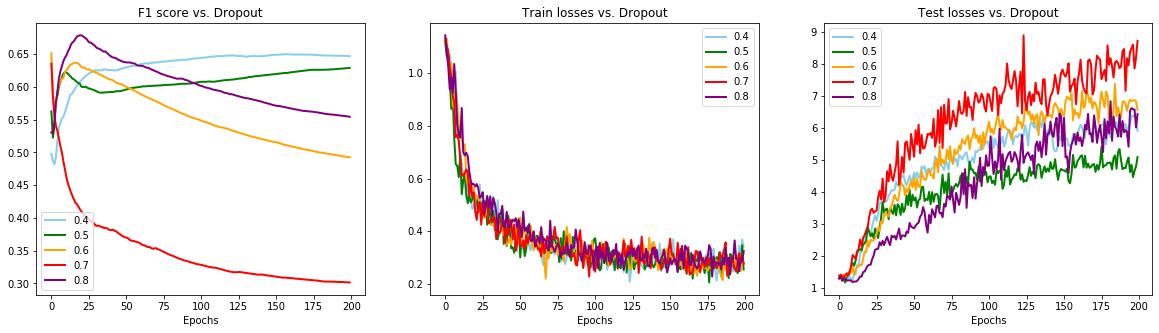

In [12]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Dropout")

In [14]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python file
import pickle
with open('resultsAttentionDropout_ANM.pickle', 'wb') as f:
    pickle.dump( rSnpRnaA_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpRnaB_tst_nXNS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixA, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( attention_matrixB, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( tst_prediction, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    


Data saved into pickle.
